Neo is a widely used Python package for analysing electrophysiology data. Here we will use it to visualise our data in order to pick out any abnormalities in the data.

In [1]:
import neo
import numpy as np
import quantities as pq
import urllib
import unittest
from scipy import signal
from numpy import mean
from neo.core import Block
from neo.core.analogsignal import AnalogSignal
from matplotlib import pyplot as plt

The neo.io module serves to load a large number of data formats used in neurophysiology. In this case, we call upon the Spike2IO class which has been designed specifically to read Spike2 files (.smr)

In [2]:
from neo.io import Spike2IO

The structure of Neo objects follows a set hierarchy. Blocks are the highest level container, encapsulating all other components. Here we read our file, and read the block within that file.

In [3]:
# create a reader
reader = neo.io.Spike2IO(filename='VR_prototype_traces.smr', try_signal_grouping=False)
# read the block
bl = reader.read(lazy=False)[0]

The next section accesses segments, the next level within the hierarchy after blocks. Within segments are the data we are interested in, which comes under the class AnalogSignal.

In [4]:
for seg in bl.segments:
    print(seg)
for asig in seg.analogsignals:
    print(asig)
for st in seg.spiketrains:
    print(st)

[[0.00015259]
 [0.00076294]
 [0.00076294]
 ...
 [0.14846802]
 [0.13534546]
 [0.13458252]] V
[[-3.985138 ]
 [-3.982544 ]
 [-3.983307 ]
 ...
 [-1.2149048]
 [-1.2168884]
 [-1.2149048]] V
[[-0.00350952]
 [ 0.00183105]
 [ 0.        ]
 ...
 [-0.0012207 ]
 [-0.00152588]
 [-0.00152588]] V
[[0.0012207 ]
 [0.00091553]
 [0.00259399]
 ...
 [0.00259399]
 [0.00030518]
 [0.00183105]] V


The next piece of code simply shows us the data we have loaded, here we can see the names of our channels and basic information on the AnalogSignal of each channel, including sampling rate, time of activity, and length of channel.

In [5]:
bl

Block with 1 segments, 4 groups
annotations: {'system_id': 3}
file_origin: 'VR_prototype_traces.smr'
# segments (N=1)
0: Segment with 4 analogsignals, 1 events
   annotations: {'system_id': 3}
   # analogsignals (N=4)
   0: AnalogSignal with 1 channels of length 10605; units V; datatype float32 
      name: 'Velocity'
      annotations: {'stream_id': '0'}
      sampling rate: 100.0 Hz
      time: 0.0 s to 106.05 s
   1: AnalogSignal with 1 channels of length 10604; units V; datatype float32 
      name: 'Position'
      annotations: {'stream_id': '1'}
      sampling rate: 100.0 Hz
      time: 0.0024999999999999996 s to 106.0425 s
   2: AnalogSignal with 1 channels of length 10604; units V; datatype float32 
      name: 'Reward'
      annotations: {'stream_id': '2'}
      sampling rate: 100.0 Hz
      time: 0.004999999999999999 s to 106.045 s
   3: AnalogSignal with 1 channels of length 10604; units V; datatype float32 
      name: 'Licks'
      annotations: {'stream_id': '3'}
      sam

Here we plot out our signals, giving us our first look at the data in Neo. We can see that there does appear to be some relationships in the data. For example, licking behaviour occurs roughly when the reward pulse is delivered, as expected. We are also able to see the peak response in the data. This is particularly important for velocity, as it gives us a good idea of how fast the animal is running throughout the experiment to see if this reflects mouse behaviour in a naturalistic setting.

Analyzing segment 1
Analyzing segment 2
Analyzing segment 3
Analyzing segment 4


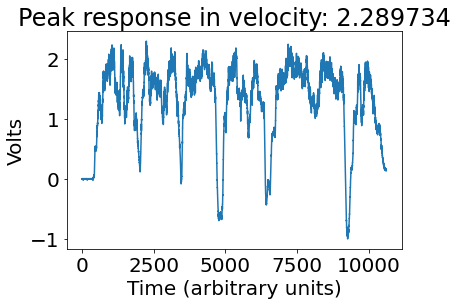

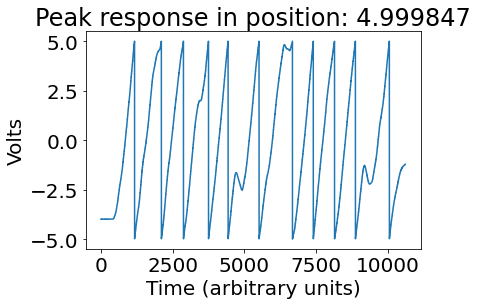

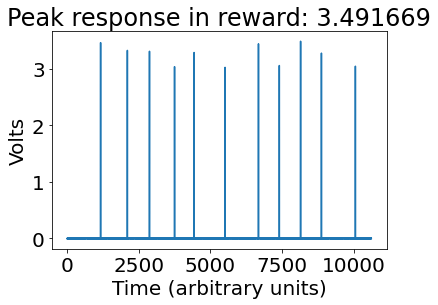

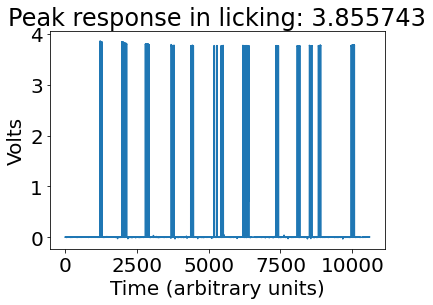

In [6]:
plt.rcParams.update({'font.size': 20})

for seg in bl.segments:
    print("Analyzing segment 1")
    avg = np.mean(seg.analogsignals[0], axis=1)
    plt.figure()
    plt.plot(avg)
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Volts')
    plt.title("Peak response in velocity: %f" % (avg.max()))

for seg in bl.segments:
    print("Analyzing segment 2")
    avg = np.mean(seg.analogsignals[1], axis=1)
    plt.figure()
    plt.plot(avg)
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Volts')
    plt.title("Peak response in position: %f" % (avg.max()))

for seg in bl.segments:
    print("Analyzing segment 3")
    avg = np.mean(seg.analogsignals[2], axis=1)
    plt.figure()
    plt.plot(avg)
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Volts')
    plt.title("Peak response in reward: %f" % (avg.max()))

for seg in bl.segments:
    print("Analyzing segment 4")
    avg = np.mean(seg.analogsignals[3], axis=1)
    plt.figure()
    plt.plot(avg)
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Volts')
    plt.title("Peak response in licking: %f" % (avg.max()))

Though these plots give us a good idea of what is going on in the data, overlaying these plots will provide a much clearer picture of what is occuring on a given trial. We can conceptualise a trial as the time between the peak and trough in the Position trace, as this shows the mouse's position along the track. Each lap is one trial.

SEG: VR_prototype_traces.smr


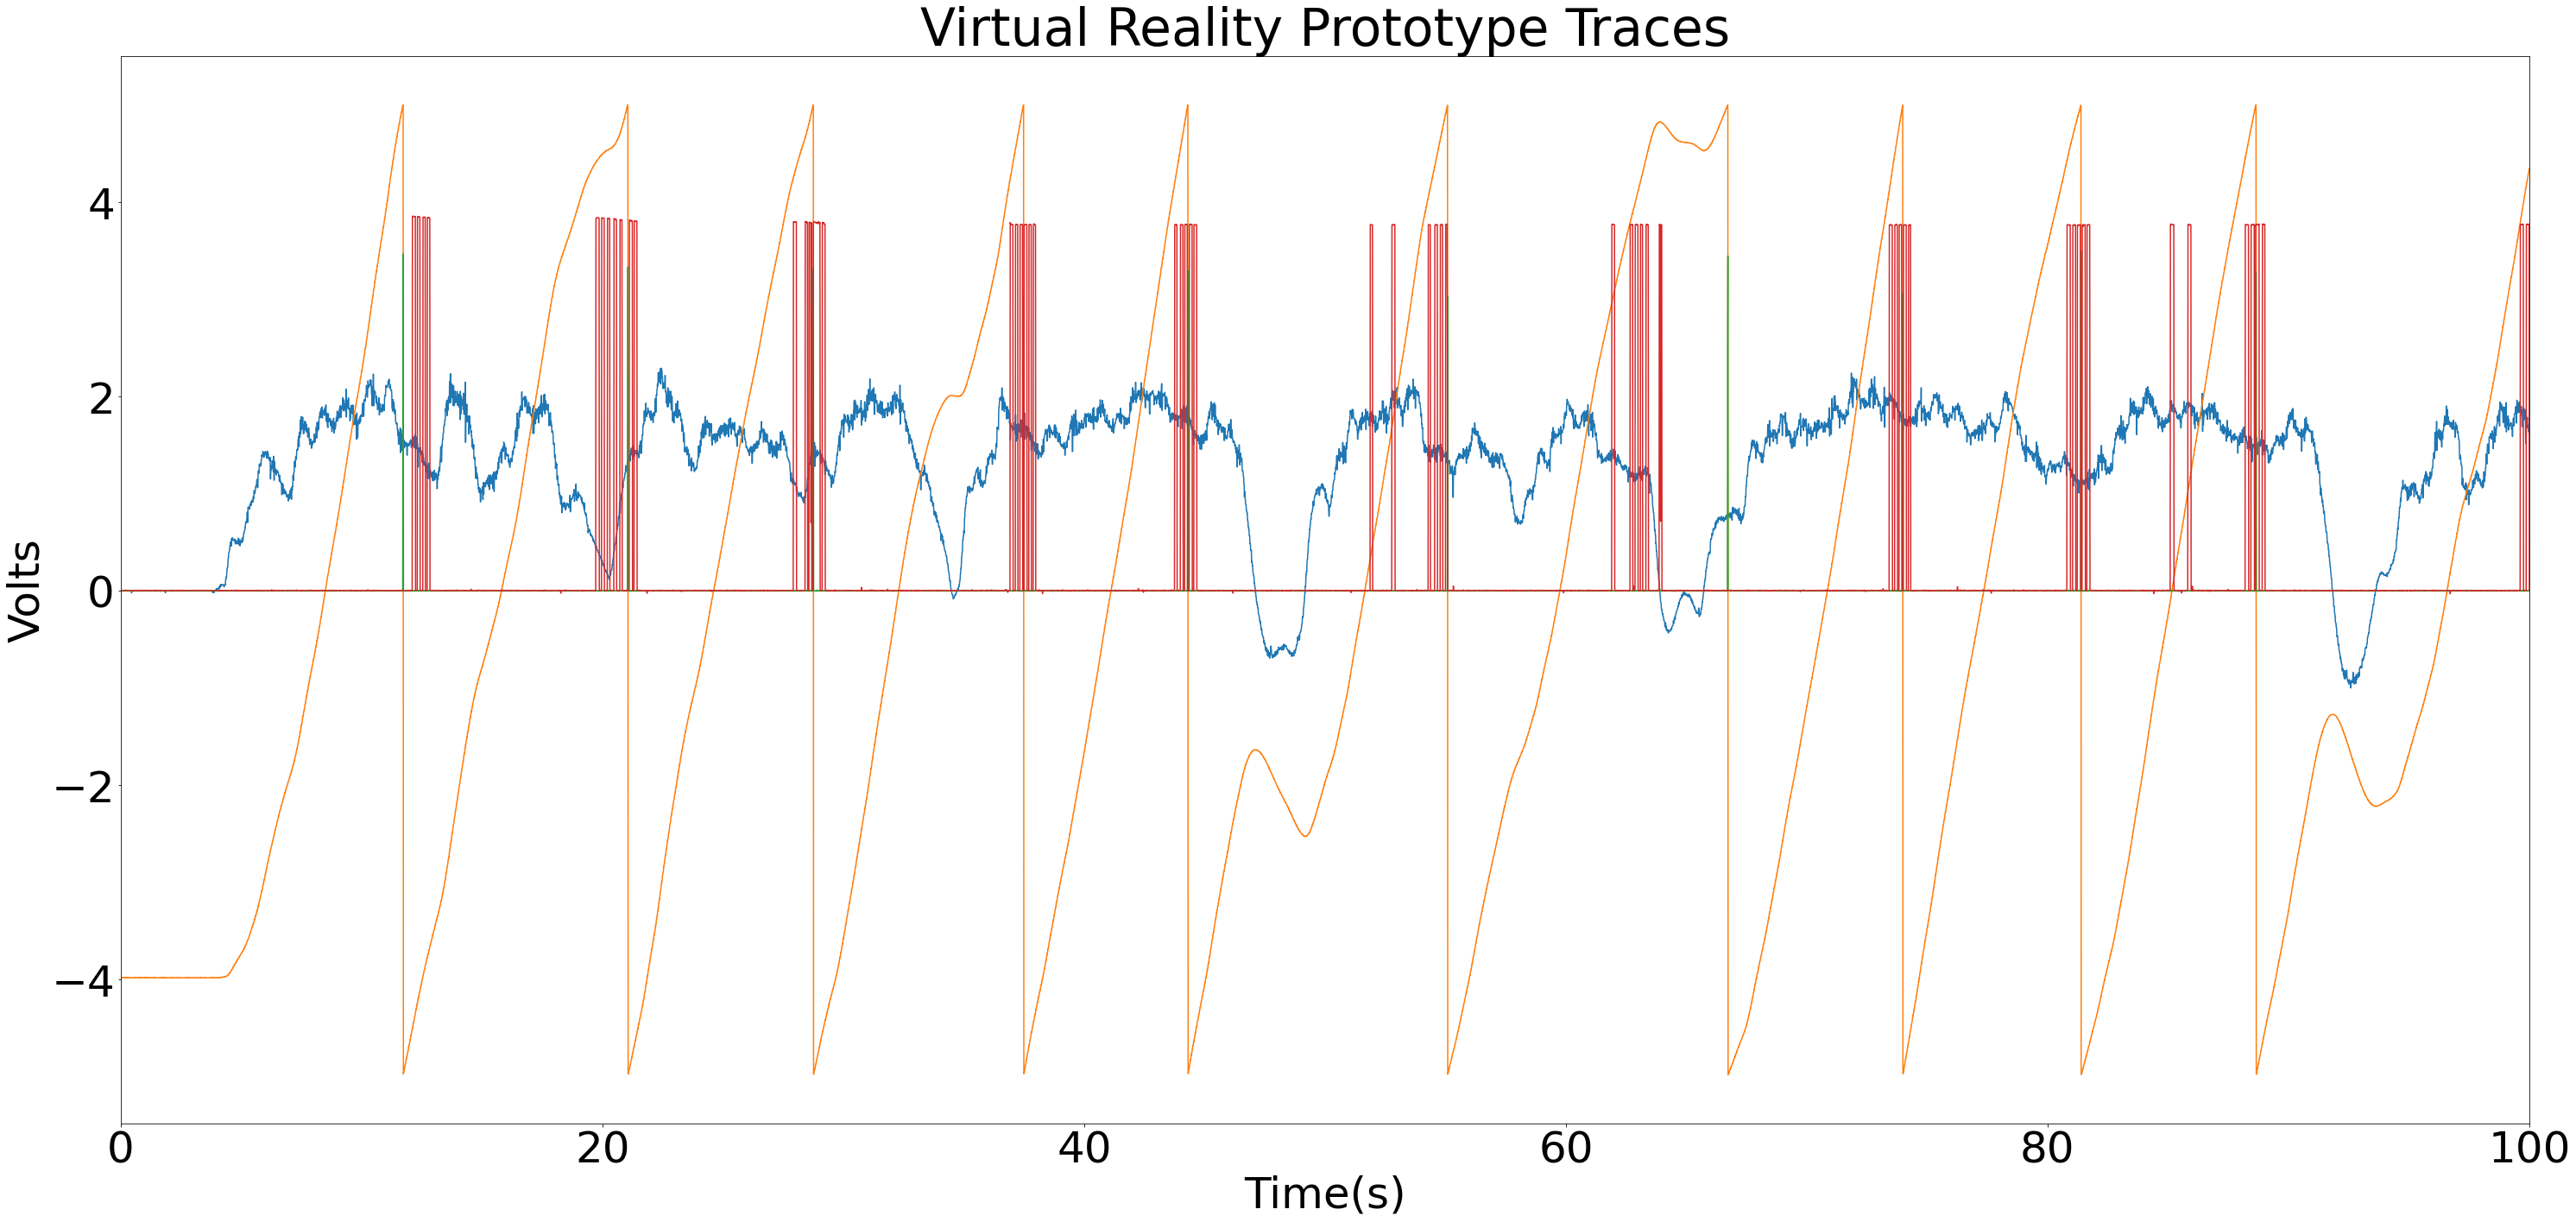

In [7]:
begin = 0; end = 100
plt.rcParams.update({'font.size': 50})
bl = reader.read(lazy=False)[0]
for seg in bl.segments:
    print("SEG: " + str(seg.file_origin))
    fig = plt.figure(figsize = (50,50))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title('Virtual Reality Prototype Traces')
    ax1.set_ylabel('Volts')
    ax1.set_xlabel('Time(s)')
    ax1.set_xlim(begin,end)
    mint = 0 * pq.s
    maxt = np.inf * pq.s
    for i, asig in enumerate(seg.analogsignals):
        times = asig.times.rescale('s').magnitude
        asig = asig.magnitude
        ax1.plot(times, asig)

    trains = [st.rescale('s').magnitude for st in seg.spiketrains]
    colors = plt.cm.jet(np.linspace(0, 1, len(seg.spiketrains)))

plt.show()

This has given us a great visualisation of our data, however the data itself appears quite noisy. It is difficult to separate traces for licks, for example. Our velocity data should be smoothed out as well, as it will give us a clearer picture on how the animal's movement changed throughout the task. 

This code will import and install a custom plugin, spike2py, into Python. This plugin is designed to interpret and analyse data from Spike2, a program centered around multi-channel continuous gathering and analysis of electrophysiological data. Spike2py allows us to use basic signal processing methods on our data , giving us a clearer idea of the story throughout the experiment.

In [8]:
pip install spike2py

Note: you may need to restart the kernel to use updated packages.


In [9]:
import spike2py

In order for files to be read by spike2py, they must be in .mat format. The file format generated by Spike2 is .smr. As such, custom code (included in the ZIP file) was written (credit: Martin Heroux, https://github.com/MartinHeroux/Spike2-batch-export-to-Matlab) to export .smr files to .mat format.

The following code imports the data into Python using spike2py. The two classes included, Trial and TrialInfo provide the information needed to visualise and analyse our data.

In [10]:
from spike2py.trial import TrialInfo, Trial
trial_info = TrialInfo()
trial_info

TrialInfo(
	file=None,
	channels=None,
	name=None, 
	subject_id=None,
	path_save_figures=None,
	path_save_trial=None,
)

The above cell demonstrates what happens when we do not provide any input for TrialInfo, thus demonstrating the importance of including these variables. The next piece of code includes the reading of the appropriate file (this should be in the same directory as your Jupyter Notebook).

In [11]:
from spike2py.trial import TrialInfo, Trial
trial_info = TrialInfo(file='VR_prototype_traces.mat')
data = Trial(trial_info)
trial_info

TrialInfo(
	file='VR_prototype_traces.mat',
	channels=None,
	name=None, 
	subject_id=None,
	path_save_figures=None,
	path_save_trial=None,
)

Check that our file has been uploaded correctly - there should be 5 channels:
    Velocity
    Position
    Reward
    Licks
    Keyboard

In [12]:
data


VR_prototype_traces
	file = file:///C:/Users/dg453/VR_prototype_traces.mat
	subject_id = sub
	path_save_figures = figures
	path_save_trial = data
	channels 
		Velocity (waveform)
		Position (waveform)
		Reward (waveform)
		Licks (waveform)
		Keyboard (keyboard)

Now we will visualise the data to give us an idea of how best to interpret it. Spike2py comes with its own built-in plotting method.

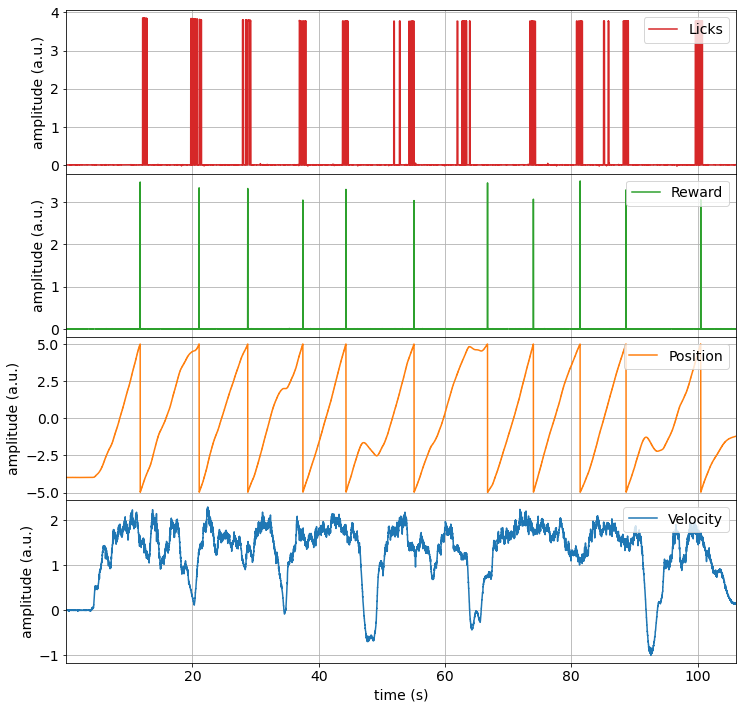

In [13]:
data.plot()

This data is noisy, it is important to use signal processing to give us a clearer picture of what is happening in the data.

The following section applies a Butterworth low pass filter of 5Hz to the data, thus reducing noise and allowing more accurate interpretation of the data.

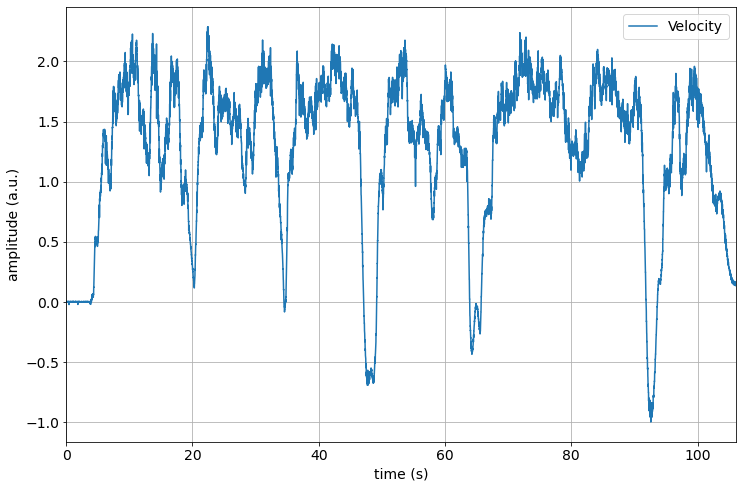

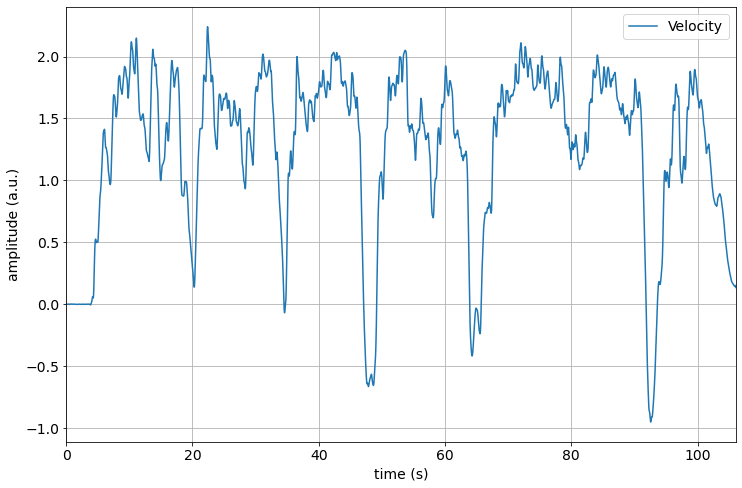

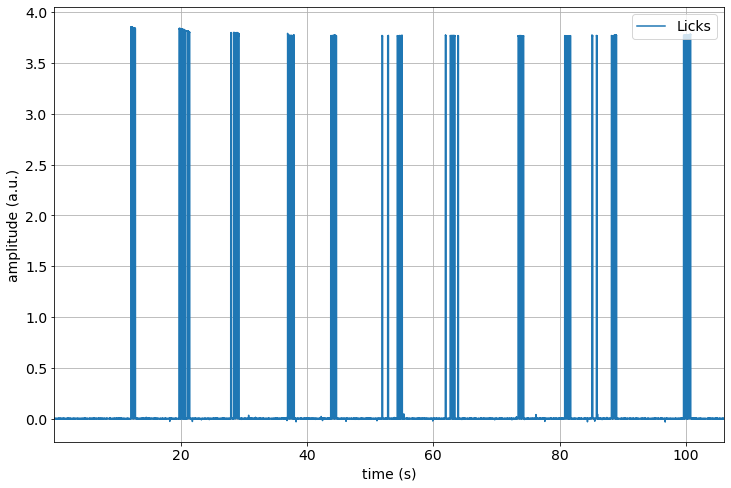

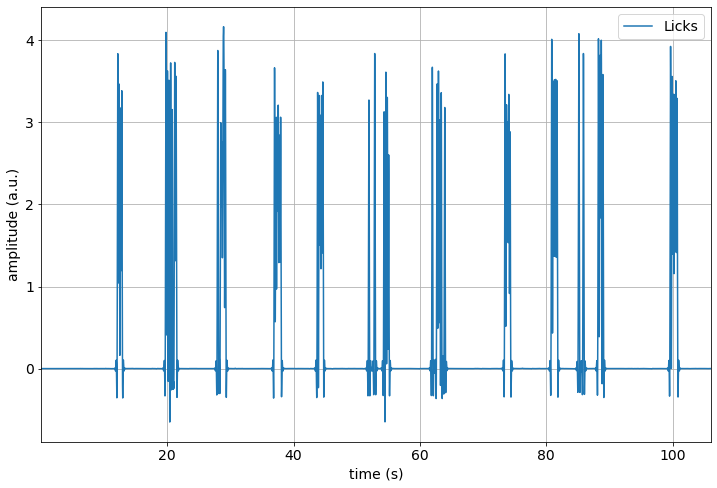

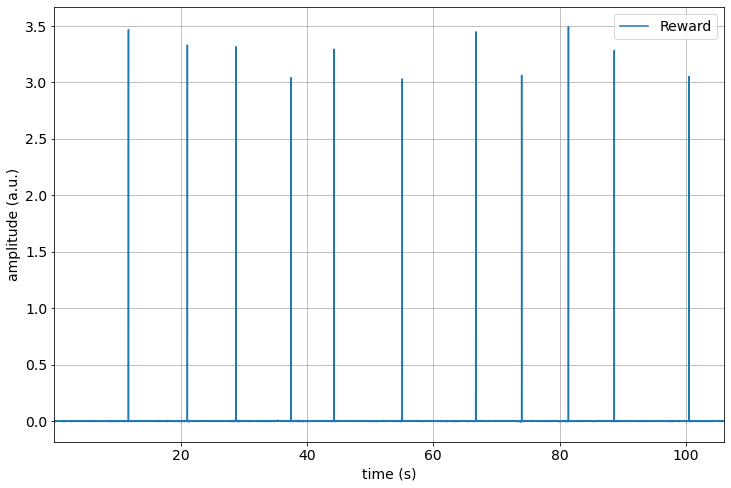

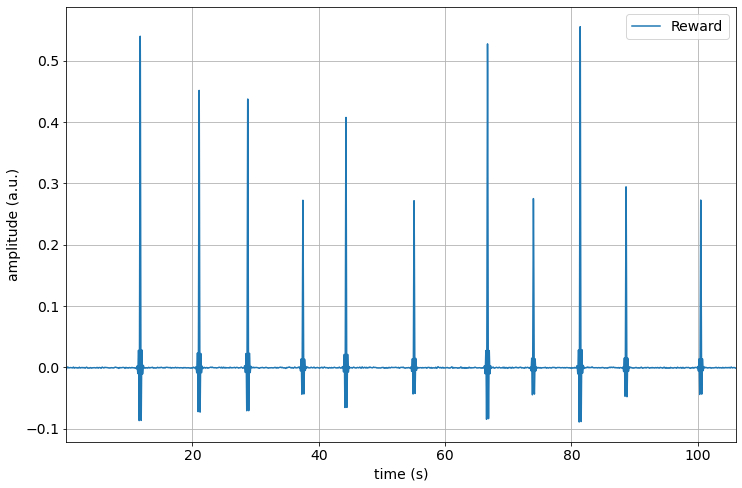

Waveform channel

In [14]:
data.Velocity.plot()
data.Velocity.lowpass(cutoff=5)
data.Velocity.lowpass(cutoff=5).plot()

data.Licks.plot()
data.Licks.lowpass(cutoff=5).plot()

data.Reward.plot()
data.Reward.lowpass(cutoff=5)
data.Reward.lowpass(cutoff=5).plot()

The following section rectifies the data in the Licks and Reward waveforms. This replaces negative data values -x with +x and leaves positive values unchanged.

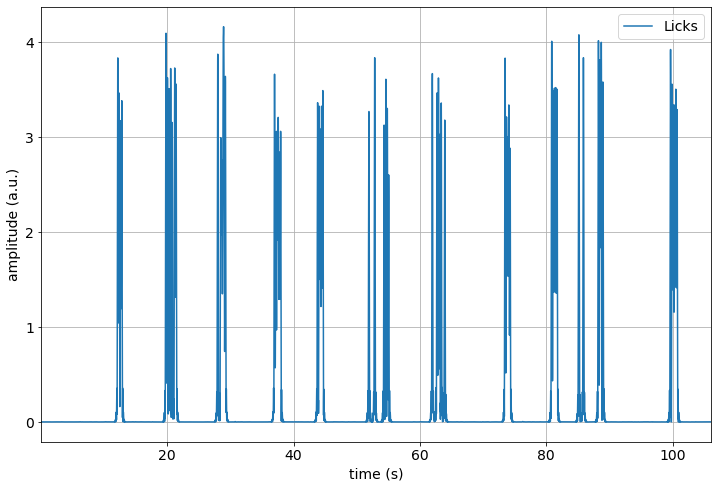

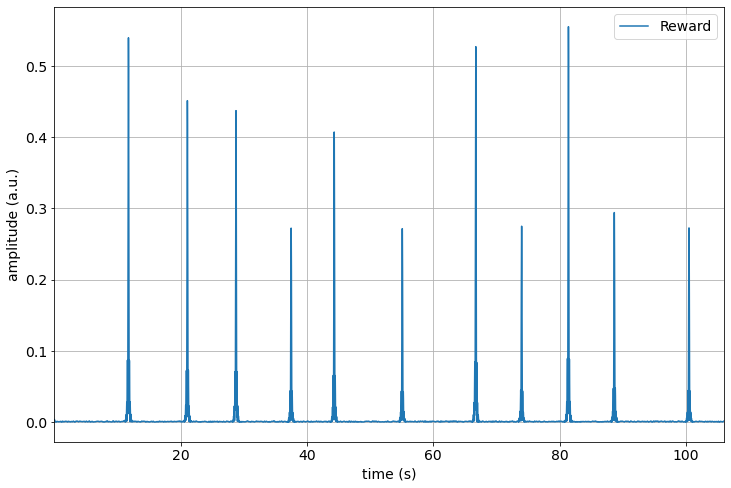

Waveform channel

In [15]:
data.Licks.rect()
data.Licks.rect().plot()

data.Reward.rect()
data.Reward.rect().plot()

We now plot the data once more, having undergone the necessary signal processing. This gives us a much clearer picture of what is happening on each trial.

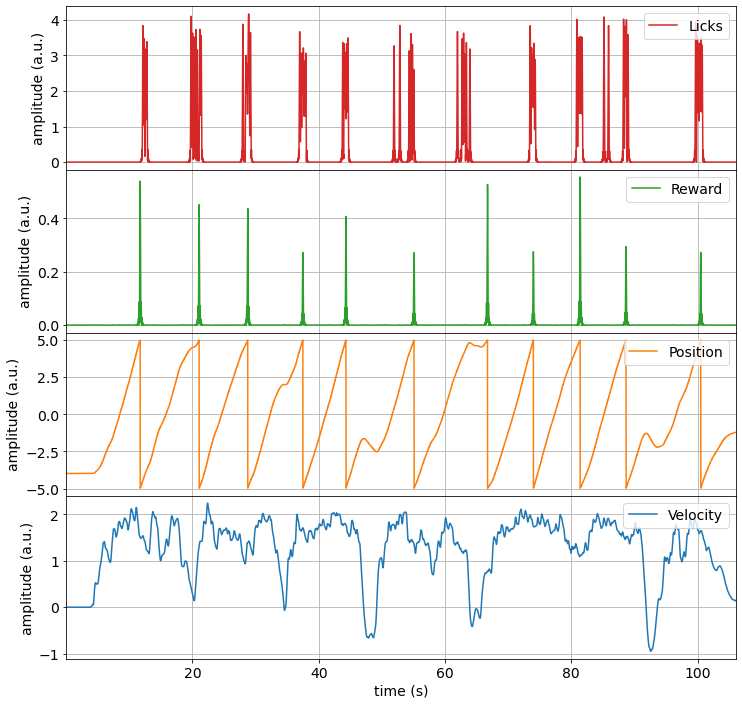

In [16]:
data.plot()

The .highpass command applies a 20hz band-pass filter on this channel, effectively 'zooming out' of the signal and giving us a clearer picture.

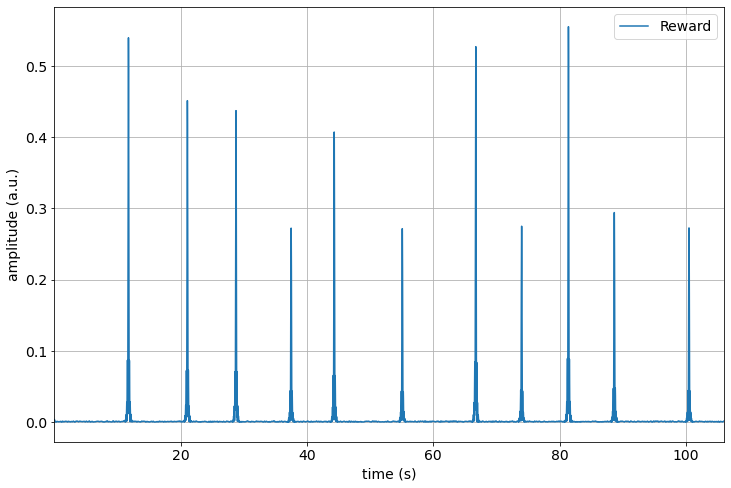

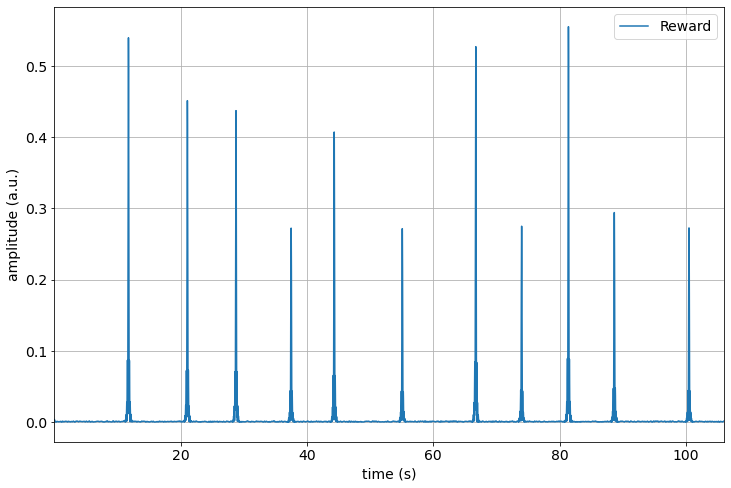

Waveform channel

In [17]:
data.Reward.plot()
data.Reward.rect().plot()

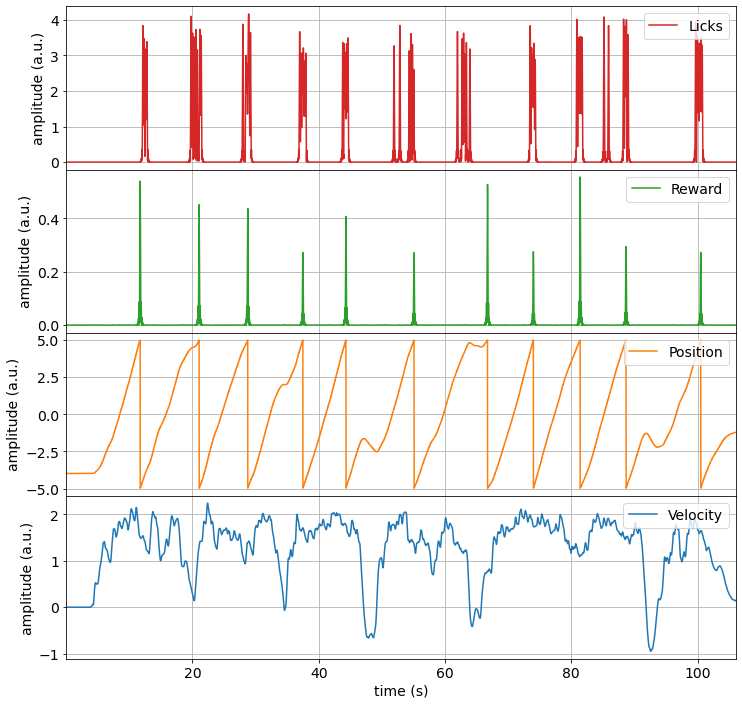

In [18]:
data.plot()

In [19]:
data.save()

Our data is now saved in a directory called 'data' created in the folder in which the dataset exists. If you wanted to reload your saved data, you'd enter the following code:

In [20]:
from pathlib import Path
data = spike2py.trial.load(file=Path('.' /
                 data.info.path_save_trial /
                 data.info.name).with_suffix('.pkl'))

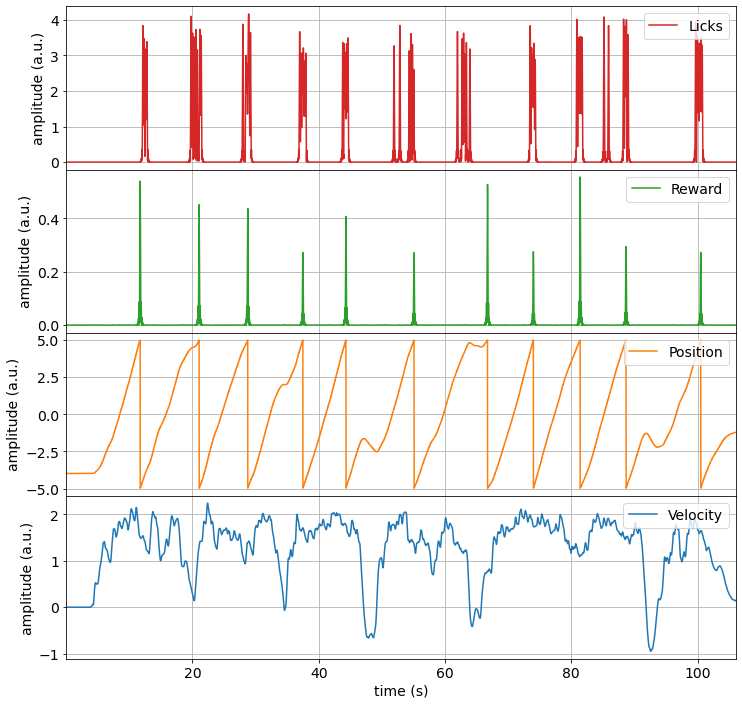

In [21]:
data.plot()

Here we can see our data has been saved in a .pkl format, with all of our signal processing maintained. We now have a much cleaner dataset from which we can quickly examine behavioural artefacts and determine whether further statistical analysis is required. For the purposes of the prototype, it is enough to see that all signals are activating correctly and there does not seem to be any strange anomalies in the data that do not match up with the physical or virtual behaviour.